In [91]:
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt

In [80]:
! ls ~/Downloads/

Rscores_epoch_1


In [74]:
with open("/Users/fmokhtar/Downloads/top_fraction_epoch_1.pkl", "rb") as f:
    out = pickle.load(f)

In [75]:
out

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan])

In [79]:
    # same: list of counters, for each N, of edges connecting the same subjet
    top_same, qcd_same = np.array([0] * N_values), np.array([0] * N_values)
    # diff: list of counters, for each N, of edges connecting different subjets
    top_diff, qcd_diff = np.array([0] * N_values), np.array([0] * N_values)


NameError: name 'N_values' is not defined

In [113]:
outpath = "/Users/fmokhtar/Downloads/"
epoch = 1
N_values=15
N_SUBJETS=3
JET_ALGO="CA"
jet_radius=0.8

In [92]:
    # same: list of counters, for each N, of edges connecting the same subjet
    top_same, qcd_same = np.array([0] * N_values), np.array([0] * N_values)
    # diff: list of counters, for each N, of edges connecting different subjets
    top_diff, qcd_diff = np.array([0] * N_values), np.array([0] * N_values)

    PATH = f"{outpath}/Rscores_epoch_{epoch}"
    save_as = f"epoch_{epoch}"
    legend_title = f"Model at epoch {epoch}"


In [338]:

    with open(f"{PATH}/batch_y.pkl", "rb") as handle:
        batch_y_list = pkl.load(handle)
    with open(f"{PATH}/batch_p4.pkl", "rb") as handle:
        batch_p4_list = pkl.load(handle)
    with open(f"{PATH}/batch_x.pkl", "rb") as handle:
        batch_x_list = pkl.load(handle)        

    # load the edgeRscores and edge_index of each EdgeConv block
    with open(f"{PATH}/R_edges.pkl", "rb") as handle:
        R_edges_list = pkl.load(handle)
    with open(f"{PATH}/edge_index.pkl", "rb") as handle:
        edge_index_list = pkl.load(handle)

    Num_jets = len(batch_p4_list)

FileNotFoundError: [Errno 2] No such file or directory: '/Users/fmokhtar/Downloads/Rscores_epoch_19/batch_x.pkl'

In [103]:
import awkward as ak
import fastjet
import vector
vector.register_awkward()
    

In [343]:
! ls /Users/fmokhtar/Downloads/

Rscores_epoch_1      Rscores_untrained
Rscores_epoch_19     data_0.pt.crdownload


In [782]:
subjet_idxs = {}
edge_Rscoress = {}
top_fraction, qcd_fraction = {}, {}

JET_ALGO = "CA"
N = 3

l = [
#     "Rscores_untrained",
    "old3",
    "old_new",
    "old_new_again",
#     "Rscores_lol",
#     "old2",
#     "Rscores_epoch_1",    
#     "Rscores_epoch_19"    
]


for test in l:
    PATH = "/Users/fmokhtar/Downloads/"
    PATH += test

    edge_Rscoress[test], subjet_idxs[test] = {}, {}
    edge_Rscoress[test]["Top"], edge_Rscoress[test]["QCD"] = None, None
    subjet_idxs[test]["Top"], subjet_idxs[test]["QCD"] = None, None

    with open(f"{PATH}/batch_y.pkl", "rb") as handle:
        batch_y_list = pkl.load(handle)
    # load the edgeRscores and edge_index of each EdgeConv block
    with open(f"{PATH}/R_edges.pkl", "rb") as handle:
        R_edges_list = pkl.load(handle)
    with open(f"{PATH}/edge_index.pkl", "rb") as handle:
        edge_index_list = pkl.load(handle)
    
    # load the jet information
    if "Rscores" in test:
        with open(f"{PATH}/batch_p4.pkl", "rb") as handle:
            batch_p4_list = pkl.load(handle)    
    else:   # old
        with open(f"{PATH}/batch_px.pkl", "rb") as handle:
            batch_px_list = pkl.load(handle)
        with open(f"{PATH}/batch_py.pkl", "rb") as handle:
            batch_py_list = pkl.load(handle)
        with open(f"{PATH}/batch_pz.pkl", "rb") as handle:
            batch_pz_list = pkl.load(handle)
        with open(f"{PATH}/batch_E.pkl", "rb") as handle:
            batch_E_list = pkl.load(handle)

    # same: list of counters, for each N, of edges connecting the same subjet
    top_same, qcd_same = 0, 0
    # diff: list of counters, for each N, of edges connecting different subjets
    top_diff, qcd_diff = 0, 0

    for i in range(100):
        jet_label = batch_y_list[i]
        if "Rscores" in test:
            px = batch_p4_list[i][:, 0]
            py = batch_p4_list[i][:, 1]
            pz = batch_p4_list[i][:, 2]
            e = batch_p4_list[i][:, 3]
            edge_Rscores = R_edges_list[i]["edge_conv_2"]
            edge_index = edge_index_list[i]["edge_conv_2"]
        else:
            px = batch_px_list[i]
            py = batch_py_list[i]
            pz = batch_pz_list[i]
            e = batch_E_list[i]

            if "old_new" in test:
                edge_Rscores = R_edges_list[i]["edge_conv_2"]
                edge_index = edge_index_list[i]["edge_conv_2"]
            
            elif "old_2" in test:
                # sum over the latent features' edge Rscores
                edge_Rscores = torch.abs(R_edges_list[i]["edge_conv_2"]).sum(axis=1)
                # normalize the sum of edge Rscores of all jets to be 1
                edge_Rscores = edge_Rscores / sum(edge_Rscores)
                edge_index = edge_index_list[i]["edge_conv_2"]
            else:
                # sum over the latent features' edge Rscores
                edge_Rscores = torch.abs(R_edges_list[i]).sum(axis=1)
                # normalize the sum of edge Rscores of all jets to be 1
                edge_Rscores = edge_Rscores / sum(edge_Rscores)
                edge_index = edge_index_list[i]                

        try:
            subjet_idx, _ = get_subjets(px, py, pz, e, N_SUBJETS, JET_ALGO, jet_radius)
        except:
            print("ERROR")
            continue

        if jet_label == 1:
            if edge_Rscoress[test]["Top"] == None:
                edge_Rscoress[test]["Top"] = torch.topk(edge_Rscores, N+1).values.tolist()
                subjet_idxs[test]["Top"] = subjet_idx.tolist()
            else:
                edge_Rscoress[test]["Top"] += torch.topk(edge_Rscores, N+1).values.tolist()
                subjet_idxs[test]["Top"] += subjet_idx.tolist()
        else:
            if edge_Rscoress[test]["QCD"] == None:
                edge_Rscoress[test]["QCD"] = torch.topk(edge_Rscores, N+1).values.tolist()
                subjet_idxs[test]["QCD"] = subjet_idx.tolist()
            else:
                edge_Rscoress[test]["QCD"] += torch.topk(edge_Rscores, N+1).values.tolist()
                subjet_idxs[test]["QCD"] += subjet_idx.tolist()                

        for edge in torch.topk(edge_Rscores, N+1).indices:
            if jet_label == 1:
                if subjet_idx[edge_index[0][edge]] != subjet_idx[edge_index[1][edge]]:
                    top_diff += 1
                else:
                    top_same += 1
            else:
                if subjet_idx[edge_index[0][edge]] != subjet_idx[edge_index[1][edge]]:
                    qcd_diff += 1
                else:
                    qcd_same += 1   
                    
    top_fraction[test] = top_diff / (top_same + top_diff)
    qcd_fraction[test] = qcd_diff / (qcd_same + qcd_diff)                    

In [ ]:
top_fraction, qcd_fraction = {}, {}

In [865]:
PATH

'/Users/fmokhtar/Downloads/k12d2/'

In [866]:
with open(f"/Users/fmokhtar/Downloads/model_kwargs.pkl", "rb") as handle:
    mode = pkl.load(handle)

In [867]:
mode

{'node_feat_size': 7, 'num_classes': 1, 'k': 12}

In [868]:


JET_ALGO = "CA"
N = 3

l = [
#     "Rscores_untrained",
#     "old3",
#     "old_new",
#     "old_new_again",
#     "old_new_again2",
#     "old_new_again3",
#     "old_new_again5",
#     "old_new_again6",
    "old_all",
#     "old_old",
#     "old11",
#     "old12",
#     "old8",
#     "old9",
#     "old10",
    
#     "Rscores_lol",
#     "old2",
#     "Rscores_epoch_1",    
#     "Rscores_epoch_19"    
]


# for test in l:
#     PATH = "/Users/fmokhtar/Downloads/"
#     PATH += test

#     edge_Rscoress[test], subjet_idxs[test] = {}, {}
#     edge_Rscoress[test]["Top"], edge_Rscoress[test]["QCD"] = None, None
#     subjet_idxs[test]["Top"], subjet_idxs[test]["QCD"] = None, None

#     with open(f"{PATH}/batch_y.pkl", "rb") as handle:
#         batch_y_list = pkl.load(handle)
#     # load the edgeRscores and edge_index of each EdgeConv block
#     with open(f"{PATH}/R_edges.pkl", "rb") as handle:
#         R_edges_list = pkl.load(handle)
#     with open(f"{PATH}/edge_index.pkl", "rb") as handle:
#         edge_index_list = pkl.load(handle)
    
#     # load the jet information
#     if "Rscores" in test:
#         with open(f"{PATH}/batch_p4.pkl", "rb") as handle:
#             batch_p4_list = pkl.load(handle)    
#     else:   # old
#         with open(f"{PATH}/batch_px.pkl", "rb") as handle:
#             batch_px_list = pkl.load(handle)
#         with open(f"{PATH}/batch_py.pkl", "rb") as handle:
#             batch_py_list = pkl.load(handle)
#         with open(f"{PATH}/batch_pz.pkl", "rb") as handle:
#             batch_pz_list = pkl.load(handle)
#         with open(f"{PATH}/batch_E.pkl", "rb") as handle:
#             batch_E_list = pkl.load(handle)

#     # same: list of counters, for each N, of edges connecting the same subjet
#     top_same, qcd_same = 0, 0
#     # diff: list of counters, for each N, of edges connecting different subjets
#     top_diff, qcd_diff = 0, 0

#     for i in range(800):
#         jet_label = batch_y_list[i]
#         if "Rscores" in test:
#             px = batch_p4_list[i][:, 0]
#             py = batch_p4_list[i][:, 1]
#             pz = batch_p4_list[i][:, 2]
#             e = batch_p4_list[i][:, 3]
#             edge_Rscores = R_edges_list[i]["edge_conv_2"]
#             edge_index = edge_index_list[i]["edge_conv_2"]
#         else:
#             px = batch_px_list[i]
#             py = batch_py_list[i]
#             pz = batch_pz_list[i]
#             e = batch_E_list[i]

#             if "old_new" == test:
#                 edge_Rscores = R_edges_list[i]["edge_conv_2"]
#                 edge_index = edge_index_list[i]["edge_conv_2"]
#             elif "old_new" in test:
#                 edge_Rscores = R_edges_list[i]["edge_conv_2"]
#                 edge_index = edge_index_list[i]["edge_conv_2"]            
            
#             elif "old_all" in test: #old_2
#                 # sum over the latent features' edge Rscores
#                 edge_Rscores = torch.abs(R_edges_list[i]["edge_conv_2"]).sum(axis=1)
#                 # normalize the sum of edge Rscores of all jets to be 1
#                 edge_Rscores = edge_Rscores / sum(edge_Rscores)
#                 edge_index = edge_index_list[i]["edge_conv_2"]
#             else:
#                 # sum over the latent features' edge Rscores
#                 edge_Rscores = torch.abs(R_edges_list[i]).sum(axis=1)
#                 # normalize the sum of edge Rscores of all jets to be 1
#                 edge_Rscores = edge_Rscores / sum(edge_Rscores)
#                 edge_index = edge_index_list[i]                

#         try:
#             subjet_idx, _ = get_subjets(px, py, pz, e, N_SUBJETS, JET_ALGO, jet_radius)
#         except:
#             print("ERROR")
#             continue

#         for edge in torch.topk(edge_Rscores, N+1).indices:
#             if jet_label == 1:
#                 if subjet_idx[edge_index[0][edge]] != subjet_idx[edge_index[1][edge]]:
#                     top_diff += 1
#                 else:
#                     top_same += 1
#             else:
#                 if subjet_idx[edge_index[0][edge]] != subjet_idx[edge_index[1][edge]]:
#                     qcd_diff += 1
#                 else:
#                     qcd_same += 1   
                    
#     top_fraction[test] = top_diff / (top_same + top_diff)
#     qcd_fraction[test] = qcd_diff / (qcd_same + qcd_diff)
    
    
    
    
Top_N = 15
top_same = np.array([0] * Top_N)
top_diff = np.array([0] * Top_N)
qcd_same = np.array([0] * Top_N)
qcd_diff = np.array([0] * Top_N)

# PATH = "/Users/fmokhtar/Downloads/Rscores_4/"
# PATH = "/Users/fmokhtar/Downloads/k8d3/"
PATH = "/Users/fmokhtar/Downloads/new_old/"

with open(f'{PATH}/batch_y.pkl', 'rb') as handle:
    batch_y_list = pkl.load(handle)    
with open(f'{PATH}/R_edges.pkl', 'rb') as handle:
    R_edges_list = pkl.load(handle)    
with open(f'{PATH}/edge_index.pkl', 'rb') as handle:
    edge_index_list = pkl.load(handle)

with open(f'{PATH}/batch_px.pkl', 'rb') as handle:
    batch_px_list = pkl.load(handle)
with open(f'{PATH}/batch_py.pkl', 'rb') as handle:
    batch_py_list = pkl.load(handle)  
with open(f'{PATH}/batch_pz.pkl', 'rb') as handle:
    batch_pz_list = pkl.load(handle)
with open(f'{PATH}/batch_E.pkl', 'rb') as handle:
    batch_E_list = pkl.load(handle)  

Num_jets = len(batch_px_list)
for i in range(Num_jets):
    jet_label = batch_y_list[i]

    R_edges = R_edges_list[i]
    edge_index_dic = edge_index_list[i]

    px = batch_px_list[i]
    py = batch_py_list[i]
    pz = batch_pz_list[i]
    e = batch_E_list[i]

    # get subjets
    try:
        subjet_idx, subjet_vectors = get_subjets(px, py, pz, e)
    except:
        print(f"skipping jet # {i}")
        continue

#     # top N edges
#     edge_index, edge_weight = edge_index_dic["edge_conv_2"], torch.abs(R_edges["edge_conv_2"]).sum(axis=1)
#     edge_Rscores = edge_weight/sum(edge_weight)  # normalize sum of Rscores of all jets to be 1

    edge_index, edge_Rscores = edge_index_dic, R_edges

    for N in range(Top_N):
        for edge in torch.topk(edge_Rscores, N+1).indices:   # N=0 doesn't make sense here
            if jet_label==1:
                if subjet_idx[edge_index[0][edge]]!=subjet_idx[edge_index[1][edge]]:
                    top_diff[N] += 1
                else:
                    top_same[N] += 1
            else:
                if subjet_idx[edge_index[0][edge]]!=subjet_idx[edge_index[1][edge]]:      
                    qcd_diff[N] += 1
                else:
                    qcd_same[N] += 1


top_fraction = top_diff/(top_same+top_diff)
qcd_fraction = qcd_diff/(qcd_same+qcd_diff)    

skipping jet # 801
skipping jet # 894


In [869]:
top_fraction

array([0.64132554, 0.61598441, 0.61273554, 0.61306043, 0.60974659,
       0.60233918, 0.59760512, 0.59381092, 0.59302577, 0.58927875,
       0.58692185, 0.58544509, 0.58524516, 0.58075745, 0.57933723])

In [870]:
qcd_fraction

array([0.47291667, 0.44270833, 0.4625    , 0.46979167, 0.47416667,
       0.47673611, 0.48065476, 0.48046875, 0.47986111, 0.47916667,
       0.48106061, 0.4828125 , 0.48766026, 0.48958333, 0.48708333])

(0.0, 1.0)

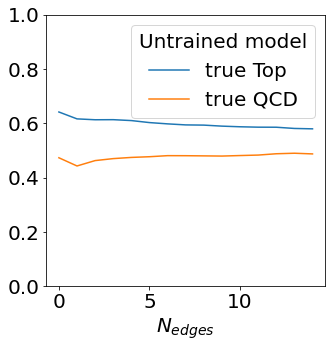

In [871]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(range(len(top_fraction)), top_fraction, label='true Top')
ax.plot(range(len(qcd_fraction)), qcd_fraction, label='true QCD')

ax.legend(title='Untrained model')
ax.set_xlabel(r'$N_{edges}$', fontsize=20)
ax.set_ylim(0,1)

(0.0, 1.0)

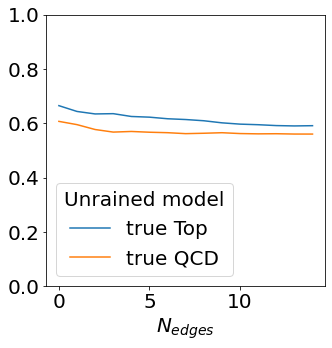

In [847]:
fig, ax = plt.subplots(figsize=(5, 5))   # 1
ax.plot(range(len(top_fraction)), top_fraction, label='true Top')
ax.plot(range(len(qcd_fraction)), qcd_fraction, label='true QCD')

ax.legend(title='Untrained model')
ax.set_xlabel(r'$N_{edges}$', fontsize=20)
ax.set_ylim(0,1)

(0.0, 1.0)

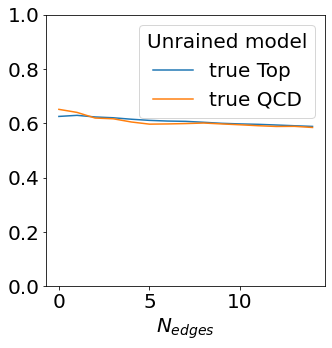

In [851]:
fig, ax = plt.subplots(figsize=(5, 5))  # 2
ax.plot(range(len(top_fraction)), top_fraction, label='true Top')
ax.plot(range(len(qcd_fraction)), qcd_fraction, label='true QCD')

ax.legend(title='Untrained model')
ax.set_xlabel(r'$N_{edges}$', fontsize=20)
ax.set_ylim(0,1)

(0.0, 1.0)

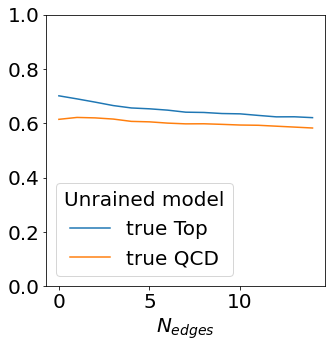

In [853]:
fig, ax = plt.subplots(figsize=(5, 5))   # 3
ax.plot(range(len(top_fraction)), top_fraction, label='true Top')
ax.plot(range(len(qcd_fraction)), qcd_fraction, label='true QCD')

ax.legend(title='Untrained model')
ax.set_xlabel(r'$N_{edges}$', fontsize=20)
ax.set_ylim(0,1)

(0.0, 1.0)

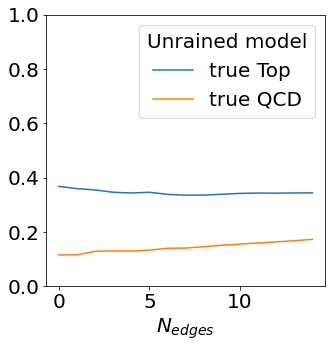

In [861]:
fig, ax = plt.subplots(figsize=(5, 5))   # k8d3
ax.plot(range(len(top_fraction)), top_fraction, label='true Top')
ax.plot(range(len(qcd_fraction)), qcd_fraction, label='true QCD')

ax.legend(title='Untrained model')
ax.set_xlabel(r'$N_{edges}$', fontsize=20)
ax.set_ylim(0,1)

(0.0, 1.0)

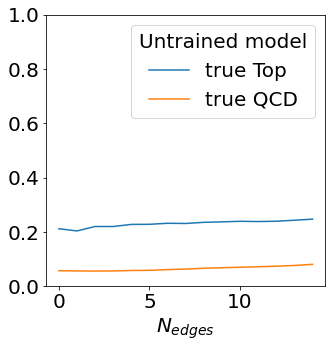

In [864]:
fig, ax = plt.subplots(figsize=(5, 5))   # k12d2
ax.plot(range(len(top_fraction)), top_fraction, label='true Top')
ax.plot(range(len(qcd_fraction)), qcd_fraction, label='true QCD')

ax.legend(title='Untrained model')
ax.set_xlabel(r'$N_{edges}$', fontsize=20)
ax.set_ylim(0,1)

In [816]:
for test in top_fraction:
    print(test)
    print("top: ", top_fraction[test])
    print("qcd: ", qcd_fraction[test])
    print("ratio", top_fraction[test]/qcd_fraction[test])
    print("--------------------------")

old10
top:  0.4577380952380952
qcd:  0.3353174603174603
ratio 1.3650887573964499
--------------------------
old7
top:  0.4652956298200514
qcd:  0.3014705882352941
ratio 1.5434196501348048
--------------------------
old11
top:  0.46364795918367346
qcd:  0.3197530864197531
ratio 1.4500187140493264
--------------------------
old_old
top:  0.4987980769230769
qcd:  0.4127604166666667
ratio 1.2084445522931326
--------------------------
old_all
top:  0.4680989583333333
qcd:  0.3363526570048309
ratio 1.3916909784560143
--------------------------


In [793]:
for test in top_fraction:
    print(test)
    print("top: ", top_fraction[test])
    print("qcd: ", qcd_fraction[test])
    print("ratio", top_fraction[test]/qcd_fraction[test])
    print("--------------------------")

old_new_again2
top:  0.42045454545454547
qcd:  0.3125
ratio 1.3454545454545455
--------------------------
old_new_again3
top:  0.47959183673469385
qcd:  0.3333333333333333
ratio 1.4387755102040816
--------------------------
old_new_again5
top:  0.44
qcd:  0.29
ratio 1.517241379310345
--------------------------
old_new_again6
top:  0.5
qcd:  0.1989795918367347
ratio 2.5128205128205128
--------------------------


In [810]:
print(test)
top_fraction[test]/qcd_fraction[test]

old7


1.5434196501348048

In [738]:
        with open(f"/Users/fmokhtar/Downloads/model_kwargs_old.pkl", "rb") as f:
            old_model_kwargs = pkl.load(f)
        with open(f"/Users/fmokhtar/Downloads/model_kwargs.pkl", "rb") as f:
            model_kwargs = pkl.load(f)

In [737]:
model_kwargs

{'for_LRP': False,
 'node_feat_size': 7,
 'num_classes': 1,
 'k': 12,
 'depth': 1,
 'dropout': True}

In [739]:
old_model_kwargs

{'node_feat_size': 7, 'num_classes': 1, 'k': 12}

In [742]:
from typing import Callable, Union

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor
from torch_cluster import knn_graph
from torch_geometric.nn import global_mean_pool
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.typing import Adj, PairTensor


class EdgeConv_lrp(MessagePassing):
    """
    Copied from pytorch_geometric source code, with the following edits
    1. torch.cat([x_i, x_j - x_i], dim=-1)) -> torch.cat([x_i, x_j], dim=-1))
    2. retrieve edge_activations
    """

    def __init__(self, nn: Callable, aggr: str = "max", **kwargs):
        super().__init__(aggr=aggr, **kwargs)
        self.nn = nn

    def forward(self, x: Union[Tensor, PairTensor], edge_index: Adj) -> Tensor:
        if isinstance(x, Tensor):
            x: PairTensor = (x, x)
        # propagate_type: (x: PairTensor)
        return (
            self.propagate(edge_index, x=x, size=None),
            self.edge_activations,
        )

    def message(self, x_i: Tensor, x_j: Tensor) -> Tensor:
        # self.edge_activations = self.nn(torch.cat([x_i, x_j - x_i], dim=-1))
        # return self.nn(torch.cat([x_i, x_j - x_i], dim=-1))
        self.edge_activations = self.nn(torch.cat([x_i, x_j], dim=-1))
        return self.nn(torch.cat([x_i, x_j], dim=-1))

    def __repr__(self) -> str:
        return f"{self.__class__.__name__}(nn={self.nn})"


class EdgeConvBlock(nn.Module):
    def __init__(self, in_size, layer_size, depth):
        super(EdgeConvBlock, self).__init__()

        layers = []

        layers.append(nn.Linear(in_size * 2, layer_size))
        layers.append(nn.BatchNorm1d(layer_size))
        layers.append(nn.ReLU())

        for i in range(depth):
            layers.append(nn.Linear(layer_size, layer_size))
            layers.append(nn.BatchNorm1d(layer_size))
            layers.append(nn.ReLU())

        self.edge_conv = EdgeConv_lrp(nn.Sequential(*layers), aggr="mean")

    def forward(self, x, edge_index):
        return self.edge_conv(x, edge_index)


class ParticleNet(nn.Module):
    def __init__(
        self,
        for_LRP,
        node_feat_size,
        num_classes=1,
        k=16,
        depth=2,
        dropout=False,
    ):
        super(ParticleNet, self).__init__()
        self.for_LRP = for_LRP

        self.node_feat_size = node_feat_size
        self.num_classes = num_classes

        self.k = k
        self.num_edge_conv_blocks = 3

        self.kernel_sizes = [self.node_feat_size, 64, 128, 256]
        self.input_sizes = np.cumsum(self.kernel_sizes)  # [4, 4+64, 4+64+128, 4+64+128+256]

        self.fc_size = 256

        if dropout:
            self.dropout = 0.1
            self.dropout_layer = nn.Dropout(p=self.dropout)
        else:
            self.dropout = None

        # define the edgeconvblocks
        self.edge_conv_blocks = nn.ModuleList()
        for i in range(0, self.num_edge_conv_blocks):
            self.edge_conv_blocks.append(EdgeConvBlock(self.input_sizes[i], self.kernel_sizes[i + 1], depth=depth))

        # define the fully connected networks (post-edgeconvs)
        self.fc1 = nn.Linear(self.input_sizes[-1], self.fc_size)
        self.fc2 = nn.Linear(self.fc_size, self.num_classes)

        self.sig = nn.Sigmoid()

    def forward(self, batch):
        x = batch.x
        y = batch.y
        batch = batch.batch

        # input transformations
        x[:, 2] = (x[:, 2] - 1.7) * 0.7  # part_pt_log
        x[:, 3] = (x[:, 3] - 2.0) * 0.7  # part_e_log
        x[:, 4] = (x[:, 4] + 4.7) * 0.7  # part_logptrel
        x[:, 5] = (x[:, 5] + 4.7) * 0.7  # part_logerel
        x[:, 6] = (x[:, 6] - 0.2) * 4.7  # part_deltaR

        # useful placeholders for LRP studies
        edge_activations = {}
        edge_block_activations = {}
        edge_index = {}

        for i in range(self.num_edge_conv_blocks):
            # using only angular coords for knn in first edgeconv block
            edge_index[f"edge_conv_{i}"] = knn_graph(x[:, :2], self.k, batch) if i == 0 else knn_graph(x, self.k, batch)

            out, edge_activations[f"edge_conv_{i}"] = self.edge_conv_blocks[i](x, edge_index[f"edge_conv_{i}"])

            x = torch.cat((out, x), dim=1)  # concatenating with latent features i.e. skip connections per EdgeConvBlock

            edge_block_activations[f"edge_conv_{i}"] = x

        x = global_mean_pool(x, batch)

        x = F.relu(self.fc1(x))
        if self.dropout:
            x = self.dropout_layer(x)
        x = self.fc2(x)
        x = self.sig(x)

        # save different objects if you are running lrp studies
        if self.for_LRP:
            return x, edge_activations, edge_block_activations, edge_index
        else:
            return x, y

In [743]:
ParticleNet(**model_kwargs)

ParticleNet(
  (dropout_layer): Dropout(p=0.1, inplace=False)
  (edge_conv_blocks): ModuleList(
    (0): EdgeConvBlock(
      (edge_conv): EdgeConv_lrp(nn=Sequential(
        (0): Linear(in_features=14, out_features=64, bias=True)
        (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Linear(in_features=64, out_features=64, bias=True)
        (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU()
      ))
    )
    (1): EdgeConvBlock(
      (edge_conv): EdgeConv_lrp(nn=Sequential(
        (0): Linear(in_features=142, out_features=128, bias=True)
        (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Linear(in_features=128, out_features=128, bias=True)
        (4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU()
      ))
    )
    (2): EdgeConvB

In [746]:
old_model_kwargs["for_LRP"] = True

In [747]:
ParticleNet(**old_model_kwargs)

ParticleNet(
  (edge_conv_blocks): ModuleList(
    (0): EdgeConvBlock(
      (edge_conv): EdgeConv_lrp(nn=Sequential(
        (0): Linear(in_features=14, out_features=64, bias=True)
        (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Linear(in_features=64, out_features=64, bias=True)
        (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU()
        (6): Linear(in_features=64, out_features=64, bias=True)
        (7): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (8): ReLU()
      ))
    )
    (1): EdgeConvBlock(
      (edge_conv): EdgeConv_lrp(nn=Sequential(
        (0): Linear(in_features=142, out_features=128, bias=True)
        (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Linear(in_features=128, out_features=128, bias=True)
        (4): BatchN

In [727]:
top_fraction

{'old2': 0.5534290271132376}

In [728]:
qcd_fraction

{'old2': 0.36363636363636365}

In [708]:
# 1
ratios["0"] = {}
for test in top_fraction:
    print(test)
    print("top: ", top_fraction[test])
    print("qcd: ", qcd_fraction[test])
    print("ratio", top_fraction[test]/qcd_fraction[test])
    print("--------------------------")
    ratios["0"][test] = top_fraction[test]/qcd_fraction[test]

Rscores_untrained
top:  0.0634648370497427
qcd:  0.08123791102514506
ratio 0.7812219227313567
--------------------------
old
top:  0.5818181818181818
qcd:  0.5974025974025974
ratio 0.9739130434782609
--------------------------
Rscores_epoch_1
top:  0.05582137161084529
qcd:  0.07188160676532769
ratio 0.7765737874097007
--------------------------
Rscores_epoch_19
top:  0.035650623885918005
qcd:  0.06060606060606061
ratio 0.5882352941176471
--------------------------


In [702]:
ratios = {}

In [715]:
l_ratio = {}

l_ratio["Rscores_untrained"] = {}
l_ratio["Rscores_untrained"] = [0.78, 1.9, 1.26]

l_ratio["Rscores_epoch_1"] = {}
l_ratio["Rscores_epoch_1"] = [0.78, 1.7, 2.24]

l_ratio["Rscores_epoch_19"] = {}
l_ratio["Rscores_epoch_19"] = [0.58, 3.11, 2.5]

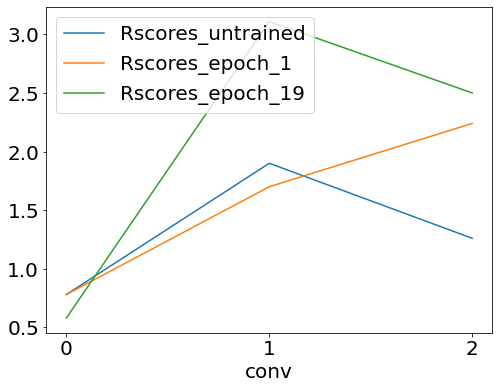

In [718]:
fig, ax = plt.subplots(figsize=(8, 6))

for model in l_ratio:
    ax.plot(l_ratio[model], label=model)

ax.set_xticks([0,1,2])
ax.set_xlabel("conv")

ax.legend();    

In [710]:
ratios

{'2': {'Rscores_untrained': 1.2601787487586893,
  'old': 0.9739130434782609,
  'Rscores_epoch_1': 2.2419075858660737,
  'Rscores_epoch_19': 2.5029088558500323},
 '1': {'Rscores_untrained': 1.8963715529753264,
  'old': 0.9739130434782609,
  'Rscores_epoch_1': 1.6973684210526316,
  'Rscores_epoch_19': 3.1176470588235294},
 '0': {'Rscores_untrained': 0.7812219227313567,
  'old': 0.9739130434782609,
  'Rscores_epoch_1': 0.7765737874097007,
  'Rscores_epoch_19': 0.5882352941176471}}

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(top, label="Top")
ax.plot(qcd, label="QCD")

ax.set_xlabel("epoch")

ax.legend();

In [712]:
l_ratio = {}
for model in ratios["0"]:
    l_ratio[model] = []

In [713]:
l_ratio

{'Rscores_untrained': [],
 'old': [],
 'Rscores_epoch_1': [],
 'Rscores_epoch_19': []}

In [ ]:
for model in l_ratio:
    for model in l_ratio[conv]:
        l_ratio[model].append(ratios[model])

In [675]:
top, qcd = [], []

with open(f"/Users/fmokhtar/Downloads/fractions/qcd_fraction_untrained.pkl", "rb") as handle:
    qcd.append(pkl.load(handle)[:15].sum())

with open(f"/Users/fmokhtar/Downloads/fractions/top_fraction_untrained.pkl", "rb") as handle:
    top.append(pkl.load(handle)[:15].sum())        
    
for i in range(40):
    if i==0:
        continue
    with open(f"/Users/fmokhtar/Downloads/fractions/qcd_fraction_epoch_{i}.pkl", "rb") as handle:
        qcd.append(pkl.load(handle)[:15].sum())
        
    with open(f"/Users/fmokhtar/Downloads/fractions/top_fraction_epoch_{i}.pkl", "rb") as handle:
        top.append(pkl.load(handle)[:15].sum())        
        

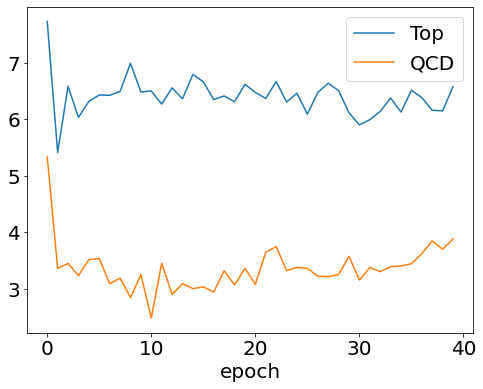

In [678]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(top, label="Top")
ax.plot(qcd, label="QCD")

ax.set_xlabel("epoch")

ax.legend();

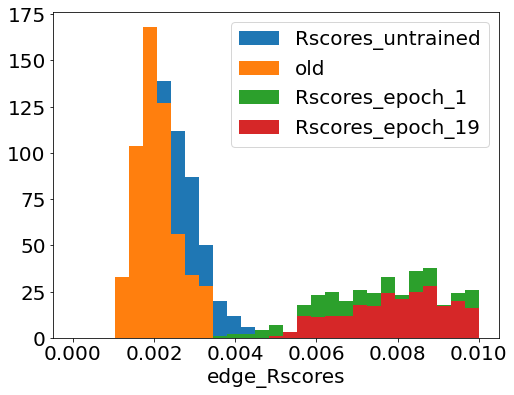

In [680]:
fig, ax = plt.subplots(figsize=(8, 6))

for key in edge_Rscoress:
    ax.hist(edge_Rscoress[key]["Top"], label=key, bins=np.linspace(0,0.01,30))

ax.set_xlabel("edge_Rscores")
ax.legend();

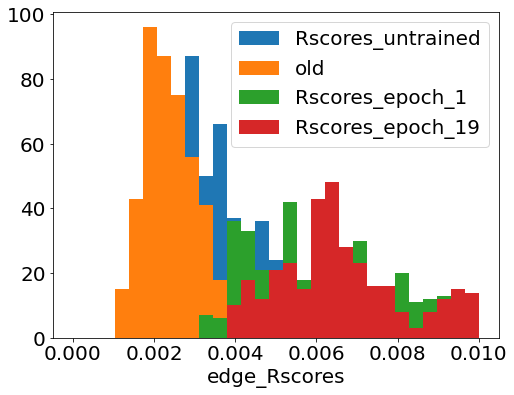

In [681]:
fig, ax = plt.subplots(figsize=(8, 6))

for key in edge_Rscoress:
    ax.hist(edge_Rscoress[key]["QCD"], label=key, bins=np.linspace(0,0.01,30))

ax.set_xlabel("edge_Rscores")
ax.legend();

In [771]:
(np.array(subjet_idxs[key]["QCD"])==1).sum()

338

In [770]:
(np.array(subjet_idxs[key]["Top"])==1).sum()

721

In [772]:
721/338

2.133136094674556

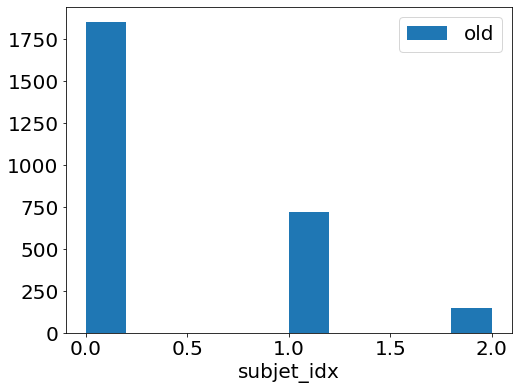

In [759]:
fig, ax = plt.subplots(figsize=(8, 6))

for key in subjet_idxs:
    ax.hist(subjet_idxs[key]["Top"], label=key)
ax.set_xlabel("subjet_idx")
ax.legend();

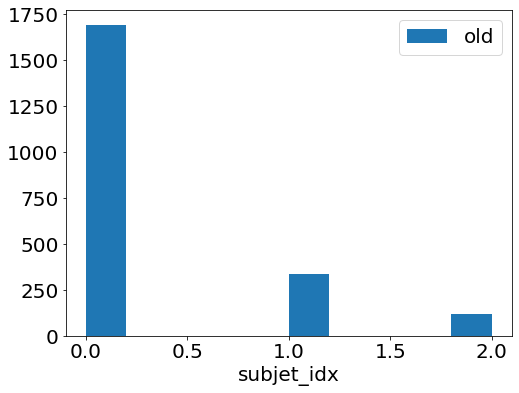

In [760]:
fig, ax = plt.subplots(figsize=(8, 6))

for key in subjet_idxs:
    ax.hist(subjet_idxs[key]["QCD"], label=key)
ax.set_xlabel("subjet_idx")
ax.legend();

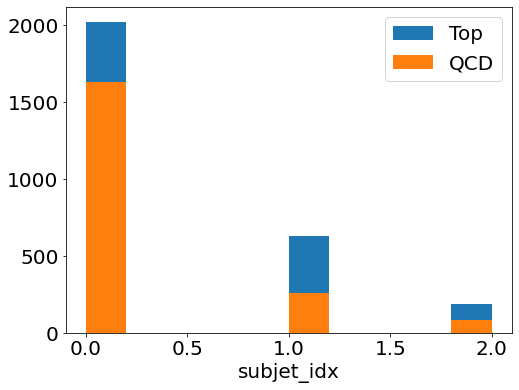

In [650]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.hist(subjet_idxs["Rscores_untrained"]["Top"], label="Top")
ax.hist(subjet_idxs["Rscores_untrained"]["QCD"], label="QCD")
ax.set_xlabel("subjet_idx")
ax.legend();

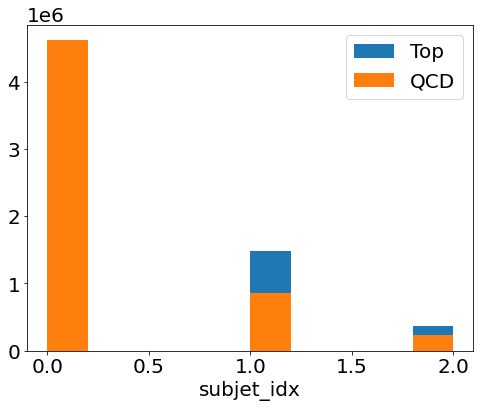

In [666]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.hist(subjet_idxs["Rscores_epoch_19"]["Top"], label="Top", weights=[len(subjet_idxs["Rscores_epoch_19"]["QCD"])] * len(subjet_idxs["Rscores_epoch_19"]["Top"]))
ax.hist(subjet_idxs["Rscores_epoch_19"]["QCD"], label="QCD", weights=[len(subjet_idxs["Rscores_epoch_19"]["Top"])] * len(subjet_idxs["Rscores_epoch_19"]["QCD"]))
ax.set_xlabel("subjet_idx")
ax.legend();

In [662]:
[len(subjet_idxs["Rscores_epoch_19"]["Top"])] * len(subjet_idxs["Rscores_epoch_19"]["Top"])

[2868,
 2868,
 2868,
 2868,
 2868,
 2868,
 2868,
 2868,
 2868,
 2868,
 2868,
 2868,
 2868,
 2868,
 2868,
 2868,
 2868,
 2868,
 2868,
 2868,
 2868,
 2868,
 2868,
 2868,
 2868,
 2868,
 2868,
 2868,
 2868,
 2868,
 2868,
 2868,
 2868,
 2868,
 2868,
 2868,
 2868,
 2868,
 2868,
 2868,
 2868,
 2868,
 2868,
 2868,
 2868,
 2868,
 2868,
 2868,
 2868,
 2868,
 2868,
 2868,
 2868,
 2868,
 2868,
 2868,
 2868,
 2868,
 2868,
 2868,
 2868,
 2868,
 2868,
 2868,
 2868,
 2868,
 2868,
 2868,
 2868,
 2868,
 2868,
 2868,
 2868,
 2868,
 2868,
 2868,
 2868,
 2868,
 2868,
 2868,
 2868,
 2868,
 2868,
 2868,
 2868,
 2868,
 2868,
 2868,
 2868,
 2868,
 2868,
 2868,
 2868,
 2868,
 2868,
 2868,
 2868,
 2868,
 2868,
 2868,
 2868,
 2868,
 2868,
 2868,
 2868,
 2868,
 2868,
 2868,
 2868,
 2868,
 2868,
 2868,
 2868,
 2868,
 2868,
 2868,
 2868,
 2868,
 2868,
 2868,
 2868,
 2868,
 2868,
 2868,
 2868,
 2868,
 2868,
 2868,
 2868,
 2868,
 2868,
 2868,
 2868,
 2868,
 2868,
 2868,
 2868,
 2868,
 2868,
 2868,
 2868,
 2868,
 2868,

In [654]:
len(subjet_idxs["Rscores_epoch_19"]["QCD"])

1990

In [656]:
subjet_idxs["Rscores_epoch_19"]["Top"]

[1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 2,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 2,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 1,
 0,
 0,
 0,
 0,
 0,
 2,
 2,


This script investigates the out.pkl produced by `../mlpf/tfmodel/timing.py`

In [4]:
! ls ../

LICENSE          environment.yml  mlpf             prp
README.md        experiments      models           requirements.txt
README_tf.md     fcc              notebooks        scripts
data             habana           out.pkl
delphes          images           parameters


In [5]:
with open("../out.pkl", "rb") as f:
    out = pickle.load(f)

In [29]:
out.keys()

dict_keys(['batch_size_1', 'batch_size_2', 'batch_size_4', 'batch_size_8', 'batch_size_16'])

In [31]:
out["batch_size_1"].keys()

dict_keys(['Nelem_256', 'Nelem_512', 'Nelem_768', 'Nelem_1024', 'Nelem_1280'])

In [32]:
out["batch_size_1"]["Nelem_256"].keys()

dict_keys(['mean', 'std', 'mem_used'])

In [34]:
out["batch_size_1"]["Nelem_256"]["mem_used"]

12.250442504882812

In [56]:
num_elems, means, stds, mem_useds = {}, {}, {}, {}
for batch_size in out:

    num_elems[batch_size] = []
    means[batch_size] = []
    stds[batch_size] = []
    mem_useds[batch_size] = []
    
    for num_elem in out[batch_size]:
        if num_elem == "Nelem_256":
            mean = out[batch_size][num_elem]["mean"]
            std = out[batch_size][num_elem]["std"]
            mem_used = out[batch_size][num_elem]["mem_used"]       

        num_elems[batch_size].append(int(num_elem[6:]))
        means[batch_size].append(out[batch_size][num_elem]["mean"]/mean)
        stds[batch_size].append(out[batch_size][num_elem]["std"]/std)
        mem_useds[batch_size].append(out[batch_size][num_elem]["mem_used"]/mem_used)    

In [57]:
num_elems[batch_size]

[256, 512, 768, 1024, 1280]

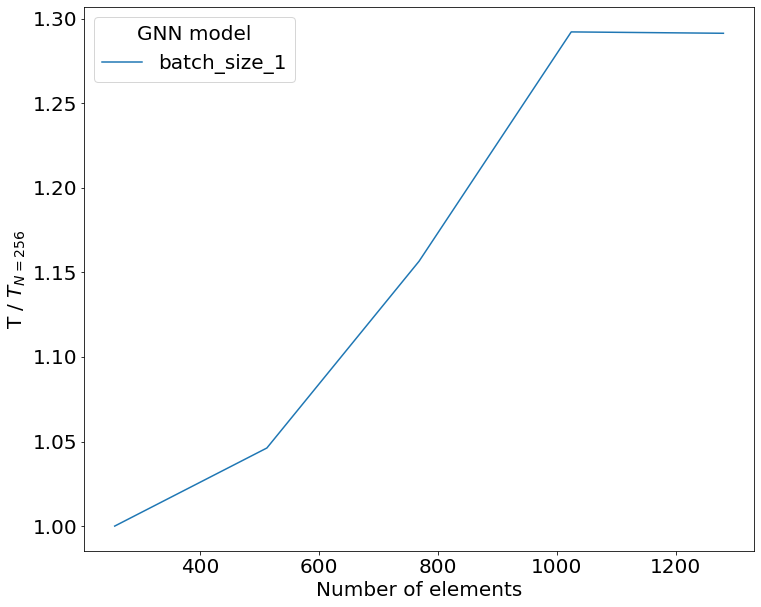

In [59]:
plt.rcParams.update({"font.size": 20})

fig, ax = plt.subplots(figsize=(12, 10))

for batch_size in num_elems:
#     ax.scatter(num_elems[batch_size], means[batch_size], label=batch_size)
    plt.errorbar(num_elems[batch_size], means[batch_size], label=batch_size)
    break
ax.legend(title="GNN model")
ax.set_ylabel(r"T / $T_{N=256}$"); 
ax.set_xlabel(r"Number of elements");
# ax.set_yscale("log")

# plt.savefig(f"/Users/fmokhtar/Desktop/scaling.pdf", bbox_inches='tight')

In [ ]:
plt.rcParams.update({"font.size": 20})
### save plot
fig, ax = plt.subplots(figsize=(9, 7))

ax.scatter(num_elems, mem_used, marker="x", label="GNN model")

ax.legend()
ax.set_ylabel(r"Memory used [MB]"); 
ax.set_xlabel(r"Number of elements");

plt.savefig(f"/Users/fmokhtar/Desktop/scaling_memory.pdf", bbox_inches='tight')